In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c sp24-tamu-csce-633-600-machine-learning --force

100% 274M/274M [00:15<00:00, 22.4MB/s]
100% 274M/274M [00:15<00:00, 19.0MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('sp24-tamu-csce-633-600-machine-learning.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split

class IMGDataset(Dataset):
    def __init__(self, X_path, Y_path):
        self.X = torch.tensor(np.load(X_path), dtype=torch.float32)
        self.Y = torch.tensor(pd.read_csv(Y_path)['label'].values)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, ix):
        image = self.X[ix].view((1, 28, 28))
        label = self.Y[ix]
        return image, label


X_TR_PATH = 'x_train_wr.npy'
Y_TR_PATH = 'y_train.csv'

img_dataset = IMGDataset(X_TR_PATH, Y_TR_PATH)
img_batch_size = 256

In [ ]:
class Loader():
  def __init__(self, dataset, batch_size, val_size):
    val_samples   = int(len(dataset)* val_size)
    train_samples = len(dataset) - val_samples

    self.dataset  = dataset
    self.train_dataset, self.val_dataset = random_split(self.dataset, [train_samples, val_samples])

    self.val_dataset.transform = False

    self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size)
    self.val_loader   = DataLoader(self.val_dataset, batch_size=batch_size)
    self.batch_size   = batch_size

In [ ]:
img_loader = Loader(img_dataset, batch_size=img_batch_size, val_size=0.2)

In [ ]:
from collections import defaultdict

digitixs = defaultdict(list)

for i in range(len(img_loader.dataset)):
  img, label = img_loader.dataset[i]
  digitixs[label.item()].append(i)

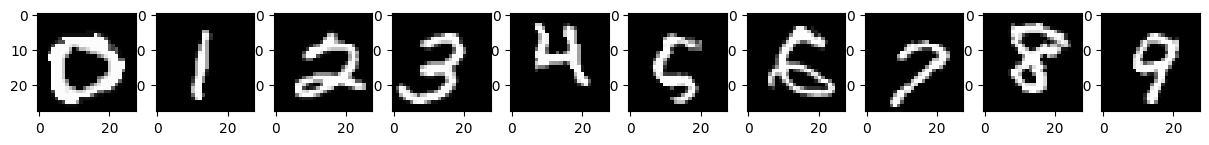

In [ ]:
import random
import matplotlib.pyplot as plt
from torchvision import transforms

img_transform = transforms.Compose([
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.95, 1.05)),
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])

plt.figure(figsize=(15, 3))
for digit in range(10):
  sampleix = random.choice(digitixs[digit])
  plt.subplot(1, 10, digit+1)
  plt.imshow(img_transform(img_loader.dataset[sampleix][0].view((1, 28, 28))).view((28, 28, 1)), cmap='gray')
plt.show()

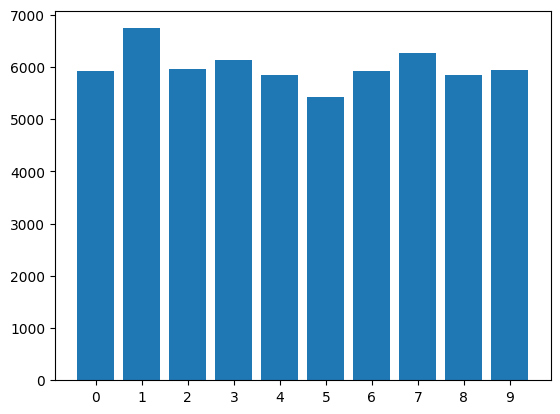

In [ ]:
plt.bar(range(10), [len(digitixs[digit]) for digit in range(10)])
plt.xticks(range(10))
plt.show()

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [ ]:
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self, filter_size=4, dropout=0.1):
    super(CNN, self).__init__()
    self.convblock1 = nn.Sequential(
      nn.Conv2d(1, 16, filter_size, 1),
      nn.ReLU(),
      nn.Dropout(dropout),
      nn.MaxPool2d(2, 1)
    )
    self.convblock2 = nn.Sequential(
      nn.Conv2d(16, 32, filter_size, 1),
      nn.ReLU(),
      nn.Dropout(dropout),
      nn.MaxPool2d(2, 1)
    )
    self.convblock3 = nn.Sequential(
      nn.Conv2d(32, 64, filter_size, 1),
      nn.ReLU(),
      nn.Dropout(dropout),
      nn.MaxPool2d(2, 1)
    )

  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    return x

  def flatten_dim(self):
    x = self.convblock1(torch.randn(1, 1, 28, 28))
    x = self.convblock2(x)
    x = self.convblock3(x)
    return x.view(-1).size(0)

In [ ]:
import torch.nn as nn
class AudioNet(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(AudioNet, self).__init__()
    self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

  def forward(self, x):
    x, _ = self.LSTM(x)
    return x

In [ ]:
class AudioDataset(Dataset):
  def __init__(self, X_path, Y_path):
    self.X = torch.tensor(np.load(X_path), dtype=torch.float32)
    self.Y = torch.tensor(pd.read_csv(Y_path)['label'].values)

  def __len__(self):
    return len(self.Y)

  def __getitem__(self, ix):
    audio = self.X[ix]
    label = self.Y[ix]
    return audio, label


In [ ]:
audio_loader = Loader(AudioDataset('x_train_sp.npy', 'y_train.csv'), batch_size=256, val_size=0.2)

In [ ]:
class MultiNet(nn.Module):
  def __init__(self, lstm_hidden_size=64, cnn_dropout=0.1, cnn_filter_size=4, embed_size=256, dense_size=512, dense_dropout=0.5):
    super(MultiNet, self).__init__()

    self.audionet = AudioNet(input_size=507, hidden_size=lstm_hidden_size)
    self.imgnet = CNN(dropout=cnn_dropout, filter_size=cnn_filter_size)

    self.audioembed = nn.Linear(lstm_hidden_size, embed_size)
    self.imgembed = nn.Linear(self.imgnet.flatten_dim(), embed_size)
    self.dense1 = nn.Sequential(
      nn.Linear(embed_size * 2, dense_size),
      nn.ReLU(),
      nn.Dropout(dense_dropout)
    )
    self.densefinal = nn.Sequential(
      nn.Linear(dense_size, 10)
    )

  def forward(self, audio, img):
    audio = self.audionet(audio)
    img = self.imgnet(img)

    audio = self.audioembed(audio.view((audio.shape[0], -1)))
    img = self.imgembed(img.view((img.shape[0], -1)))
    combined = torch.cat((audio, img), dim=1)
    combined = self.dense1(combined)
    dense = self.densefinal(combined)
    return dense


In [ ]:
from torchvision import transforms

class MultiDataset(Dataset):
  def __init__(self, audio_path, img_path, Y_path):
    self.audio = torch.tensor(np.load(audio_path), dtype=torch.float32)
    self.img = torch.tensor(np.load(img_path), dtype=torch.float32)
    self.Y = torch.tensor(pd.read_csv(Y_path)['label'].values)
    self.img_transform = transforms.Compose([
            transforms.RandomAffine(degrees=5, translate=(0.025, 0.025), scale=(0.975, 1.025)),
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
    self.transform = True

  def __len__(self):
    return len(self.Y)

  def __getitem__(self, ix):
    audio = self.audio[ix]
    img = self.img[ix].view((1, 28, 28))
    label = self.Y[ix]
    return audio, img, label

In [ ]:
multi_loader = Loader(MultiDataset('x_train_sp.npy', 'x_train_wr.npy', 'y_train.csv'), batch_size=256, val_size=0.2)

In [ ]:
import torch.nn.functional as F

def train(model, optimizer, loader, stats=False):
  best_val_loss = 1e9
  counter = 0
  val_loss_cum = []
  for epoch in range(100000):
    model.train(True)
    train_epoch_loss = 0
    for i, (audio, images, labels) in enumerate(loader.train_loader):
      audio, images, labels = audio.to(device), images.to(device), labels.to(device)

      optimizer.zero_grad()
      preds = model(audio, images)

      loss = F.cross_entropy(preds, labels)
      loss.backward()

      optimizer.step()
      train_epoch_loss += loss.item()

    model.eval()
    correct = 0
    with torch.no_grad():
      val_epoch_loss = 0
      for i, (audio, images, labels) in enumerate(loader.val_loader):
        audio, images, labels = audio.to(device), images.to(device), labels.to(device)
        preds = model(audio, images)
        loss = F.cross_entropy(preds, labels)
        val_epoch_loss += loss.item()
        correct += sum(torch.argmax(preds, dim=1) == labels)
    val_loss = val_epoch_loss / int(len(loader.val_loader.dataset) / loader.batch_size)
    val_loss_cum.append(val_loss)

    accuracy = correct.item() / len(loader.val_loader.dataset)
    if stats:
      print(f"epoch {epoch} train loss {train_epoch_loss / int(len(loader.train_loader.dataset) / loader.batch_size):.4f} val loss {val_loss:.4f} val accuracy {accuracy:.4f}")

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = model
      counter = 0
    else:
      counter += 1
      if counter >= 4:
        return best_model, best_val_loss, accuracy


In [ ]:
best_model, best_val_loss = None, 9e9

for lstm_hidden_size in [16, 32, 64, 128]:
  for embed_size in [64, 128, 256]:
    for dense_size in [256, 512, 1024]:
      for dense_dropout in [0.5, 0.6, 0.7]:
        for cnn_filter_size in [3, 4, 5]:
          for cnn_dropout in [0.1]:
            model = MultiNet(lstm_hidden_size=lstm_hidden_size, cnn_filter_size=cnn_filter_size, embed_size=embed_size, dense_size=dense_size, dense_dropout=dense_dropout, cnn_dropout=cnn_dropout).to(device)
            for lr in [1e-3, 1e-4, 1e-5]:
              optimizer = torch.optim.Adam(model.parameters(), lr=lr)
              model, val_loss, accuracy = train(model, optimizer, multi_loader)
            print(f"lstm_hidden_size: {lstm_hidden_size}, embed_size: {embed_size}, dense_size: {dense_size}, dense_dropout: {dense_dropout}, cnn_filter_size: {cnn_filter_size}, cnn_dropout: {cnn_dropout}")
            if val_loss < best_val_loss:
              print(f"New best params: lstm_hidden_size: {lstm_hidden_size}, embed_size: {embed_size}, dense_size: {dense_size}, dense_dropout: {dense_dropout}, cnn_filter_size: {cnn_filter_size}, cnn_dropout: {cnn_dropout}")
              print(f"val loss {val_loss}")
              best_val_loss = val_loss
              best_model = model
model = best_model

New best params: lstm_hidden_size: 32, embed_size: 256, dense_size: 512, dense_dropout: 0.5, cnn_filter_size: 4, cnn_dropout: 0.1
val loss 0.01975270529447184

In [ ]:
best_model, best_val_loss = None, 9e9
for batch_size in [32, 64]:
  multi_loader = Loader(MultiDataset('x_train_sp.npy', 'x_train_wr.npy', 'y_train.csv'), batch_size=batch_size, val_size=0.2)
  model = MultiNet(lstm_hidden_size=32, cnn_filter_size=4, embed_size=256, dense_size=512, dense_dropout=0.5, cnn_dropout=0.1).to(device)
  for lr in [1e-4, 1e-5, 1e-6]:
    model, val_loss, accuracy = train(model, torch.optim.Adam(model.parameters(), lr=lr), multi_loader, stats=True)
  if val_loss < best_val_loss:
    print(f"New best params: batch_size: {batch_size}")
    print(f"val loss {val_loss}")
    best_val_loss = val_loss
    best_model = model

epoch 0 train loss 0.2610 val loss 0.0859 val accuracy 0.9761
epoch 1 train loss 0.0760 val loss 0.0709 val accuracy 0.9795
epoch 2 train loss 0.0542 val loss 0.0405 val accuracy 0.9885
epoch 3 train loss 0.0414 val loss 0.0343 val accuracy 0.9900
epoch 4 train loss 0.0330 val loss 0.0318 val accuracy 0.9903
epoch 5 train loss 0.0280 val loss 0.0260 val accuracy 0.9918
epoch 6 train loss 0.0227 val loss 0.0280 val accuracy 0.9919
epoch 7 train loss 0.0208 val loss 0.0287 val accuracy 0.9906
epoch 8 train loss 0.0167 val loss 0.0290 val accuracy 0.9913
epoch 9 train loss 0.0155 val loss 0.0310 val accuracy 0.9904
epoch 0 train loss 0.0081 val loss 0.0167 val accuracy 0.9944
epoch 1 train loss 0.0060 val loss 0.0165 val accuracy 0.9941
epoch 2 train loss 0.0051 val loss 0.0160 val accuracy 0.9948
epoch 3 train loss 0.0041 val loss 0.0159 val accuracy 0.9948
epoch 4 train loss 0.0042 val loss 0.0159 val accuracy 0.9948
epoch 5 train loss 0.0036 val loss 0.0161 val accuracy 0.9948
epoch 6 

In [ ]:
import numpy as np
audio = torch.tensor(np.load('x_test_sp.npy'), dtype=torch.float32).to(device)
img = torch.tensor(np.load('x_test_wr.npy'), dtype=torch.float32).view((10000, 1, 28, 28)).to(device)

best_model.eval()
with torch.no_grad():
  labels_np = torch.argmax(best_model(audio, img), dim=1).detach().cpu().numpy()

  row_ids = np.arange(len(labels_np))
  data = np.column_stack((row_ids, labels_np))
  np.savetxt('submission.csv', data, fmt='%d', delimiter=',', header='row_id,label', comments='')

In [ ]:
labels_np